# Prosper Loan Data - Default Analysis

### Table Of Contents

* [Introduction](#intro)
* [Preprocessing: imputation of missing values](#na)
* [Dimensionality reduction: part 1](#reduce1)
* [Focusing in on default](#default)
* [Exploring the data: categorical information](#explore1)
* [Exploring the data: credit scores](#explore2)
* [Exploring the data: financial information](#explore3)
* [Exploring the data: credit history](#explore4)
* [Exploring the data: loan characteristics](#explore5)
* [Dimensionality reduction: part 2](#reduce2)
* [Preprocessing: fixing data types](#dtypes)
* [Train/test split](#split)
* [Preprocessing: scaling features to a range](#scale)
* [Dimensionality reduction: part 3](#reduce3)
* [Choosing a classifier](#class)
* [Parameter tuning](#tuning)
* [Predicting defaults](#predict)
* [Conclusion](#end)

### Introduction <a class="anchor" id="intro"></a>

This notebook will document my efforts to investigate an interesting dataset from the Prosper peer-to-peer lending platform, and to then apply some machine learning classifiers. There are many questions one could ask of this data, but in this exercise I will focus on one question specifically: whether one can successfully predict which loans will default. Prosper loans pay pretty hefty interest rates to their creditors. There is thus a significant financial incentive to accurately predicting which of the loans would eventually default or not.

The original data can be found here: https://s3.amazonaws.com/udacity-hosted-downloads/ud651/prosperLoanData.csv. A variable dictionary concisely explaining the data can be found here: https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit?usp=sharing.

I will clean the data, separate out historical data, explore the data with some visualisations, further prepare the data, and finally choose and tune a classification algorithm before a brief conclusion to wrap everything up summarizing the hypothetical financial result of using the trained classifier to predict loan default.

In [1]:
#Imports

#Data analysis and math
import math
import datetime
import numpy as np
import pandas as pd
from scipy import stats as st

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context({"figure.figsize": (15, 7.5)})

#Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile

#Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.grid_search import GridSearchCV

#Metrics
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict

from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#Input (preserve original data in case we need to refer back to it at any point)
df = original_data = pd.read_csv("../input/prosperloandata/prosperLoanData (1).csv")

pd.set_option("display.max_columns", len(df.columns))
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,NaN,NaN,NaN,NaN,NaN,NaN,0,CO,Other,Self-employed,2.0,True,True,NaN,2007-08-26 18:41:46.780000000,640.0,659.0,2001-10-11 00:00:00,5.0,4.0,12.0,1,24.0,3.0,3.0,2.0,472.0,4.0,0.0,0.0,0.0,0.00,1500.0,11.0,0.81,0.0,0.17,"$25,000-49,999",True,3083.333333,E33A3400205839220442E84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,78,19141,9425,2007-09-12 00:00:00,Q3 2007,1F3E3376408759268057EDA,330.43,11396.14,9425.00,1971.14,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,6.0,A,7.0,2,CO,Professional,Employed,44.0,False,False,NaN,2014-02-27 08:28:14,680.0,699.0,1996-03-18 00:00:00,14.0,14.0,29.0,13,389.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,3989.0,0.21,10266.0,29.0,1.00,2.0,0.18,"$50,000-74,999",True,6125.000000,9E3B37071505919926B1D82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,134815,10000,2014-03-03 00:00:00,Q1 2014,1D13370546739025387B2F4,318.93,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,NaN,NaN,NaN,NaN,NaN,NaN,0,GA,Other,Not available,NaN,False,True,783C3371218786870A73D20,2007-01-02 14:09:10.060000000,480.0,499.0,2002-07-27 00:00:00,NaN,NaN,3.0,0,0.0,0.0,1.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,Not displayed,True,2083.333333,6954337960046817851BCB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,86,6466,3001,2007-01-17 00:00:00,Q1 2007,5F7033715035555618FA612,123.32,4186.63,3001.00,1185.63,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,6.0,A,9.0,16,GA,Skilled Labor,Employed,113.0,True,False,NaN,2012-10-22 11:02:32,800.0,819.0,1983-02-28 00:00:00,5.0,5.0,29.0,7,115.0,0.0,1.0,4.0,10056.0,14.0,0.0,0.0,1444.0,0.04,30754.0,26.0,0.76,0.0,0.15,"$25,000-49,999",True,2875.000000,A0393664465886295619C51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,16,77296,10000,2012-11-01 00:00:00,Q4 2012,9ADE356069835475068C6D2,321.45,5143.20,4091.09,1052.11,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,3.0,D,4.0,2,MN

In [3]:
#Examine columns, missing values, and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             113937 non-null object
ListingNumber                          113937 non-null int64
ListingCreationDate                    113937 non-null object
CreditGrade                            28953 non-null object
Term                                   113937 non-null int64
LoanStatus                             113937 non-null object
ClosedDate                             55089 non-null object
BorrowerAPR                            113912 non-null float64
BorrowerRate                           113937 non-null float64
LenderYield                            113937 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                84853 non-null float64
ProsperRating (Alpha) 

Taking a quick look at the data, there are a few potential processing tasks that jump out right away. 

    1) Some variables have a lot of null values. TotalProsperLoans, for instance, and a lot of other variables associated with the Prosper history of the debtor.
    2) A lot of these variables seem to be administrative identifiers (e.g. ListingKey and ListingNumber), and redundant ones at that. They won't be of much use to us. 
    3) There are 17 variables of type object. Those will probably need some attention before they're ready for some of our classification models.
    4) Variables have a wide variety of ranges. We will probably need to re-scale them to make them more amenable to some of our classifiers.
    
Let's start by filling in these NaN values as best we can.

### Preprocessing: imputation of missing values <a class="anchor" id="na"></a>

Beginning with categorical data, for now let's just fill the NaN values with "Unknown".

In [4]:
categorical = df.select_dtypes(include=["object"]).columns.values
df[categorical] = df[categorical].fillna("Unknown")

df.select_dtypes(exclude=[np.number]).isnull().sum()

ListingKey                 0
ListingCreationDate        0
CreditGrade                0
LoanStatus                 0
ClosedDate                 0
ProsperRating (Alpha)      0
BorrowerState              0
Occupation                 0
EmploymentStatus           0
IsBorrowerHomeowner        0
CurrentlyInGroup           0
GroupKey                   0
DateCreditPulled           0
FirstRecordedCreditLine    0
IncomeRange                0
IncomeVerifiable           0
LoanKey                    0
LoanOriginationDate        0
LoanOriginationQuarter     0
MemberKey                  0
dtype: int64

Next, about 20 loans are missing an APR value. Because APR is equal to the borrower rate + fees, let's calculate the median difference between the two, and add that value to the borrower rate of our data points missing an APR.

In [5]:
borrower_fees = df["BorrowerAPR"] - df["BorrowerRate"]
borrower_fees.median()

0.025019999999999987

In [6]:
df["BorrowerAPR"].fillna(df["BorrowerRate"] + borrower_fees.median(), inplace=True)

df["BorrowerAPR"].isnull().sum()

0

EstimatedEffectiveYield will always be the borrower rate minus some expected loss from interest charge-offs and fees.

In [7]:
estimated_loss_from_fees = df["BorrowerRate"] - df["EstimatedEffectiveYield"]
estimated_loss_from_fees.median()

0.01915

In [8]:
df["EstimatedEffectiveYield"].fillna(df["BorrowerRate"] - estimated_loss_from_fees.median(), inplace=True)

df["EstimatedEffectiveYield"].isnull().sum()

0

EstimatedLoss is harder to gauge. Let's just take the median.

In [9]:
df["EstimatedLoss"].fillna(df["EstimatedLoss"].median(), inplace=True)

df["EstimatedLoss"].isnull().sum()

0

EstimatedReturn is defined as EstimatedEffectiveYield - EstimatedLoss.

In [10]:
df["EstimatedReturn"].fillna(df["EstimatedEffectiveYield"] - df["EstimatedLoss"], inplace=True)

df["EstimatedReturn"].isnull().sum()

0

The numeric ProsperRating and the ProsperScore NaNs can both be replaced with median values.

In [11]:
df["ProsperRating (numeric)"].fillna(df["ProsperRating (numeric)"].median(), inplace=True)
df["ProsperScore"].fillna(df["ProsperScore"].median(), inplace=True)


df["ProsperRating (numeric)"].isnull().sum(), df["ProsperScore"].isnull().sum()

(0, 0)

There are a host of variables which hold a lot of promise for our eventual classification algorithm, and are only missing a relatively small number of values. I'm going to drop all the rows missing values for these, rather than filling them out with arbitrary median values or 0s.

In [12]:
df.dropna(subset=["EmploymentStatusDuration", "CreditScoreRangeLower", "FirstRecordedCreditLine", "CurrentCreditLines",
                  "TotalCreditLinespast7years"], inplace=True)

Let's see how we're doing so far.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106290 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             106290 non-null object
ListingNumber                          106290 non-null int64
ListingCreationDate                    106290 non-null object
CreditGrade                            106290 non-null object
Term                                   106290 non-null int64
LoanStatus                             106290 non-null object
ClosedDate                             106290 non-null object
BorrowerAPR                            106290 non-null float64
BorrowerRate                           106290 non-null float64
LenderYield                            106290 non-null float64
EstimatedEffectiveYield                106290 non-null float64
EstimatedLoss                          106290 non-null float64
EstimatedReturn                        106290 non-null float64
ProsperRating (numeric)                106290 non-null float64
ProsperRating (A

It seems that most of our remaining Null values fall into four groups: 

    1) DebtToIncomeRatio, which strikes me as a potentially very useful feature. Let's take a look at what's going on there and do our best to reconstruct or substitute the missing values.
    2) ScorexChangeAtTimeOfListing, which is the difference between the borrower's credit score when it was reviewed for this loan, versus the score last time they took a Prosper loan. We'll have to think about how we can deal with that, because it's an interesting potential feature.
    2) Data dealing with the debtor's Prosper history, which we can fill with 0s to represent a lack of such history.
    3) LoanFirstDefaultedCycle, which we are actually going to drop entirely very shortly for reasons to be explained. 

In [14]:
df_debt_income_null = df[df["DebtToIncomeRatio"].isnull()]

df_debt_income_null[:5]

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),ProsperScore,ListingCategory (numeric),BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
40,10A43601079743929992413,1167746,2014-01-27 12:02:57.523000000,Unknown,60,Current,Unknown,0.19630,0.1725,0.1625,0.15163,0.0724,0.07923,4.0,C,4.0,1,WA,Other,Self-employed,276.0,False,False,Unknown,2014-01-25 10:47:25,680.0,699.0,1985-12-20 00:00:00,10.0,9.0,28.0,10,1233.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,61284.0,0.46,69166.0,28.0,1.00,2.0,NaN,"$100,000+",False,12750.0,91A33705770133108E299C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,129161,15000,2014-01-29 00:00:00,Q1 2014,ACFF370458072043753CE79,374.81,374.8100,162.14,212.6700,-12.33,0.00,0.00,0.00,0.0,1.0,0,0,0.0,3
69,0F37360159310530849DA23,1162592,2014-01-25 12:07:54.537000000,Unknown,60,Current,Unknown,0.13636,0.1139,0.1039,0.09989,0.0349,0.06499,6.0,A,11.0,1,IL,Investor,Self-employed,12.0,True,True,Unknown,2014-01-25 11:51:41,700.0,719.0,1995-08-01 00:00:00,5.0,5.0,21.0,3,373.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,19961.0,0.79,5039.0,21.0,1.00,0.0,NaN,"$25,000-49,999",False,2700.0,B08137048491184083D747A,3.0,16.0,16.0,0.0,0.0,7861.0,0.02,NaN,0,NaN,2,128889,9000,2014-01-29 00:00:00,Q1 2014,87D0340317005703964722E,197.44,194.6315,115.99,78.6415,-7.15,0.00,0.00,0.00,0.0,1.0,0,0,0.0,1
78,0DFE3425061927556BB8A75,359657,2008-06-29 23:23:40.157000000,A,36,Chargedoff,2009-04-09 00:00:00,0.18454,0.1700,0.1600,0.15085,0.0724,0.07845,4.0,Unknown,6.0,3,CA,Realtor,Full-time,68.0,True,False,Unknown,2008-06-29 23:13:04.860000000,720.0,739.0,1995-11-29 00:00:00,14.0,14.0,26.0,9,962.0,4.0,11.0,0.0,0.0,0.0,0.0,0.0,33572.0,0.73,9355.0,24.0,1.00,1.0,NaN,$0,False,0.0,B8483424568930207C77772,1.0,6.0,6.0,0.0,0.0,7750.0,6725.84,0.0,1918,9.0,68,33852,4800,2008-07-08 00:00:00,Q3 2008,D77734052911579724BCDD5,171.13,684.5200,418.38,266.1400,-15.66,0.00,4381.62,4381.62,0.0,1.0,0,0,0.0,115
100,0F67356860455769574096F,704916,2013-01-25 11:48:26.040000000,Unknown,36,Chargedoff,2013-08-30 00:00:00,0.35356,0.3134,0.3034,0.27600,0.1575,0.11850,1.0,HR,3.0,13,CA,Other,Not employed,12.0,False,False,Unknown,2013-01-11 12:10:13,720.0,739.0,2000-09-10 00:00:00,3.0,3.0,10.0,3,56.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,5641.0,0.22,19359.0,4.0,1.00,1.0,NaN,Not employed,False,0.0,9D203674230576864DAB261,1.0,11.0,7.0,4.0,0.0,5000.0,3802.10,-47.0,314,7.0,14,82947,4000,2013-01-30 00:00:00,Q1 2013,CEE83539008163122ED9B62,172.76,345.5200,144.77,200.7500,-6.41,0.00,3855.23,3855.23,0.0,1.0,0,0,0.0,73
103,0F843543787869030F017F8,579737,2012-04-17 11:58:52.270000000,Unknown,3

In [15]:
df.loc[40]

ListingKey                                   10A43601079743929992413
ListingNumber                                                1167746
ListingCreationDate                    2014-01-27 12:02:57.523000000
CreditGrade                                                  Unknown
Term                                                              60
LoanStatus                                                   Current
ClosedDate                                                   Unknown
BorrowerAPR                                                   0.1963
BorrowerRate                                                  0.1725
LenderYield                                                   0.1625
EstimatedEffectiveYield                                      0.15163
EstimatedLoss                                                 0.0724
EstimatedReturn                                              0.07923
ProsperRating (numeric)                                            4
ProsperRating (Alpha)             

In [16]:
df.loc[40, "MonthlyLoanPayment"], df.loc[40, "StatedMonthlyIncome"]

(374.81, 12750.0)

This is bizarre, because this debtor has both debt and income data available. Let's take a look at some other cases.

In [17]:
df_debt_income_null = df[df["DebtToIncomeRatio"].isnull()]

df_debt_income_null["MonthlyLoanPayment"].isnull().sum(), df_debt_income_null["StatedMonthlyIncome"].isnull().sum()

(0, 0)

All of these data points have a monthly income and monthly loan payment. Maybe it has to do with income being verifiable?

In [18]:
df_debt_income_null["IncomeVerifiable"][:10]

40     False
69     False
78     False
100    False
103    False
105    False
108    False
125    False
131    False
170    False
Name: IncomeVerifiable, dtype: bool

There we have it. The question is thus how to treat these variables. I'm inclined to calculate the Debt to Income ratio based on the stated monthly income, and to allow verifiable income to work as a feature that quantifies the risk that that income is overstated.

In [19]:
#Calculate DebtToIncomeRatio for unverifiable incomes, adding $1 to account for $0/month incomes
df["DebtToIncomeRatio"].fillna(df["MonthlyLoanPayment"] / (df["StatedMonthlyIncome"] + 1), inplace = True)

df["DebtToIncomeRatio"].isnull().sum()

0

Now let's think about how to treat the change in credit score over time. It would be very interesting to see whether a rising or a falling credit score correlates with default. Unfortunately, because it relies on a history of borrowing with Prosper, most loans are missing a value here. Unlike the other Prosper history variables, it doesn't really make sense to replace the Null values with a 0, as that would assert that the score has been constant and mislead our investigation or our models. Similarly, replacing with a measure of central tendency could throw things off. I think that, unfortunately, the most conservative approach will be to drop the column entirely.

In [20]:
df.drop("ScorexChangeAtTimeOfListing", axis=1, inplace=True)

Now let's fill the missing Prosper histories with 0s.

In [21]:
prosper_vars = ["TotalProsperLoans","TotalProsperPaymentsBilled", "OnTimeProsperPayments", "ProsperPaymentsLessThanOneMonthLate",
                "ProsperPaymentsOneMonthPlusLate", "ProsperPrincipalBorrowed", "ProsperPrincipalOutstanding"]

df[prosper_vars] = df[prosper_vars].fillna(0)

df.isnull().sum()

ListingKey                                 0
ListingNumber                              0
ListingCreationDate                        0
CreditGrade                                0
Term                                       0
LoanStatus                                 0
ClosedDate                                 0
BorrowerAPR                                0
BorrowerRate                               0
LenderYield                                0
EstimatedEffectiveYield                    0
EstimatedLoss                              0
EstimatedReturn                            0
ProsperRating (numeric)                    0
ProsperRating (Alpha)                      0
ProsperScore                               0
ListingCategory (numeric)                  0
BorrowerState                              0
Occupation                                 0
EmploymentStatus                           0
EmploymentStatusDuration                   0
IsBorrowerHomeowner                        0
CurrentlyI

### Dimensionality reduction: part 1 <a class="anchor" id="reduce1"></a>

Now that we've dealt with Null values, at least for the time being, let's see if we can't quickly get rid of some extraneous information by dropping redundant or wholly irrelevant columns from the dataset. Let's begin with redundant administrative variables.

In [22]:
df.drop(["ListingKey", "ListingNumber", "LoanKey", "LoanNumber"], axis=1, inplace=True)

There are a few other variables which could have useful information, but would necessitate a different analysis, so we will drop them too. For example, MemberKey could be used in an interesting inquiry into whether certain debtors are consistently mis-classed as risky or high-interest when in fact they consistently pay their loans back. Likewise, a time-series analysis would be very interesting: did defaults spike around the financial crisis, or do defaults become more common around Christmas? These are fascinating questions, but I think it will be better to stay focused and to drop variables like this which increase complexity unnecessarily.

In [23]:
df.drop(["ListingCreationDate", "ClosedDate", "DateCreditPulled", "LoanOriginationDate", "LoanOriginationQuarter", "MemberKey"],
        axis=1, inplace=True)

Similarly, there is a whole class of variables that describe the status of a loan at present, or the history of the loan. These are beyond the scope of this analysis. We will shortly lump delinquent loans in with defaults, and drop all loans that are current, and so, given our focus, certain columns (e.g. LoanCurrentDaysDelinquent) are irrelevant to us.

In [24]:
df.drop(["LoanCurrentDaysDelinquent", "LoanFirstDefaultedCycleNumber", "LoanMonthsSinceOrigination", "LP_CustomerPayments",
         "LP_CustomerPrincipalPayments", "LP_InterestandFees", "LP_ServiceFees", "LP_CollectionFees", "LP_GrossPrincipalLoss",
         "LP_NetPrincipalLoss", "LP_NonPrincipalRecoverypayments"], axis=1, inplace=True)

Alright, now that we have gotten rid of a couple variables which won't be helpful to the analysis, let's make sure all of our missing values have been dealt with before turning our attention to historical loans exclusively, which will be most suitable to our purposes.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106290 entries, 0 to 113936
Data columns (total 59 columns):
CreditGrade                            106290 non-null object
Term                                   106290 non-null int64
LoanStatus                             106290 non-null object
BorrowerAPR                            106290 non-null float64
BorrowerRate                           106290 non-null float64
LenderYield                            106290 non-null float64
EstimatedEffectiveYield                106290 non-null float64
EstimatedLoss                          106290 non-null float64
EstimatedReturn                        106290 non-null float64
ProsperRating (numeric)                106290 non-null float64
ProsperRating (Alpha)                  106290 non-null object
ProsperScore                           106290 non-null float64
ListingCategory (numeric)              106290 non-null int64
BorrowerState                          106290 non-null object
Occupation     

### Focusing in on default <a class="anchor" id="default"></a>

Let's investigate the data in relation to the real question: default. Let's first convert our LoanStatus variable into a binary variable excluding current loans, and visualize some of the relationships between default and other variables. 

In [26]:
df["LoanStatus"].value_counts()

Current                   56566
Completed                 33530
Chargedoff                10632
Defaulted                  3289
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     1
Name: LoanStatus, dtype: int64

What is really of interest to us is what distinguishes completed loans from defaulted loans. Because there is no way to tell whether "current" loans will eventually default or not, we can't use them for our analysis. Nearly half of the dataset is not useful to us, as the loans are still outstanding. In order to be conservative in our eventual estimates, to simplify the problem, and to retain data, let's assume all the "past due" and "chargedoff" loans (and that 1 cancellation) will default. Thus we'll be left with two classes: "completed" and "defaulted". Let's encode those binary outcomes as 1 and 0, respectively.

In [27]:
#Remove outstanding loans

df_historical = df[df["LoanStatus"] != "Current"]

df_historical["LoanStatus"].value_counts()

Completed                 33530
Chargedoff                10632
Defaulted                  3289
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     1
Name: LoanStatus, dtype: int64

In [28]:
#Encode all completed loans as 1, and all delinquent, chargedoff, cancelled and defaulted loans as 0

df_historical["LoanStatus"] = (df_historical["LoanStatus"] == "Completed").astype(int)

df_historical["LoanStatus"][:10]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0     1
11    1
12    0
15    0
21    1
23    0
26    1
27    1
30    1
33    1
Name: LoanStatus, dtype: int64

(0, 1)

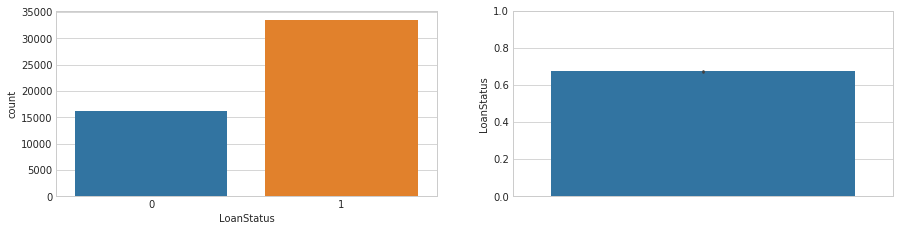

In [29]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.countplot(df_historical["LoanStatus"])

ax2 = fig.add_subplot(222)
sns.barplot(y=df_historical["LoanStatus"]).set_ylim([0,1])

In [30]:
df_historical["LoanStatus"].mean(), 1 - df_historical["LoanStatus"].mean()

(0.6743222588689567, 0.3256777411310433)

So, in the historical data as a whole, 67.43% of loans are completed. 32.57% of loans "defaulted". (During analysis, one should always bear in mind that default as we've defined it includes charge-offs, cancellations, and even any current loans with late payments. It might be more constructive to think of the loans labelled with a 0 as "bad" loans rather than outright "defaults").

Let's take a look at our new historical dataframe and then start exploring variables' relationship with default, starting with some potentially useful categorical information.

In [31]:
df_historical.describe()

,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),EmploymentStatusDuration,CreditScoreRangeLower,CreditScoreRangeUpper,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanOriginalAmount,MonthlyLoanPayment,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
count,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,4.972400e+04,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.00000
mean,37.383316,0.674322,0.227630,0.203470,0.193209,0.171487,0.084773,0.099849,3.795129,6.098906,2.846553,81.636172,682.712171,701.712171,9.586819,8.366242,25.789578,6.411210,347.684177,1.798287,6.556894,0.643914,1066.158435,4.143170,0.311178,0.023369,1.569520e+04,0.532345,10765.711789,21.844542,0.857704,0.907047,5.390154,5122.985416,0.301364,4.558624,4.412779,0.134040,0.011705,1617.444157,543.321921,6527.303495,232.774829,0.998274,0.099228,0.051022,37.083268,109.01818
std,8.200240,0.468632,0.089797,0.082468,0.082052,0.079151,0.042269,0.058222,1.365905,1.759049,3.595906,85.135799,66.713278,66.713278,5.570450,4.980212,14.263379,4.454619,450.554180,2.739781,7.182246,2.000398,6717.698686,10.026401,0.744631,0.179542,3.380213e+04,0.349553,21926.061700,12.414067,0.172177,1.235013,47.175930,5695.264678,0.645141,11.410502,11.066557,1.105551,0.258911,4286.493397,1886.611584,5270.558892,186.245160,0.019836,0.476979,0.344454,443.751112,111.41890
min,12.000000,0.000000,0.006530,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,1.000000,0.000000,0.000000,520.000000,539.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,0.000000,0.700000,0.000000,0.000000,0.000000,1.00000
25%,36.000000,0.000000,0.153240,0.136400,0.125600,0.110200,0.072400,0.060300,3.000000,6.000000,1.000000,21.000000,640.000000,659.000000,6.000000,5.000000,15.000000,3.000000,78.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.647000e+03,0.220000,512.000000,13.000000,0.770000,0.000000,0.120000,2916.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3000.000000,106.990000,1.000000,0.000000,0.000000,0.000000,33.00000
50%,36.000000,1.000000,0.222370,0.199000,0.188000,0.160850,0.072400,0.102500,4.000000,6.000000,1.000000,53.000000,680.000000,699.000000,9.000000,8.000000,24.000000,6.000000,209.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.113500e+03,0.570000,3231.000000,20.000000,0.920000,1.000000,0.200000,4250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5000.000000,173.710000,1.000000,0.000000,0.000000,0.000000,73.00000
75%,36.000000,1.000000,0.305130,0.270000,0.259900,0.236

### Exploring the data: categorical information <a class="anchor" id="explore1"></a>

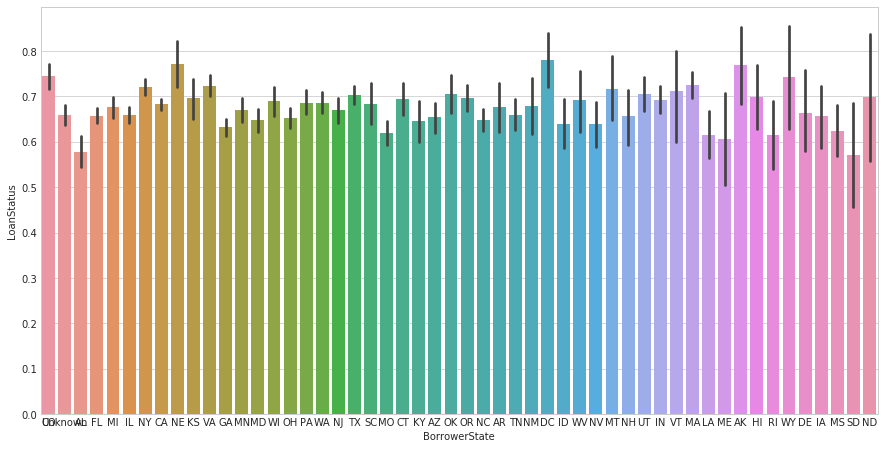

In [32]:
sns.barplot(x="BorrowerState", y="LoanStatus", data=df_historical)

In [33]:
al, dc = df_historical[df_historical["BorrowerState"] == "AL"], df_historical[df_historical["BorrowerState"] == "DC"]

1 - al["LoanStatus"].mean(), 1 - dc["LoanStatus"].mean()

(0.42205323193916355, 0.22043010752688175)

There seems to be some variation. Loans to people in Alabama defaulted 42.21% of the time, whereas loans to people in Washington D.C. only defaulted 22.04% of the time. Cool! We'll have to try to make this categorical information useable in our classifier--perhaps with dummy variables.

Let's take a look at another categorical variable: ListingCategory.

First though, it's a bit annoying having to constantly refer to our variable definitions to understand the listing category, so before we interpret this, let's change our numeric values to the actual category names. This will also be useful, because the numeric values imply some sort of false ordinality, and we should really handle this like a categorical variable.

In [34]:
df_historical.replace(to_replace={"ListingCategory (numeric)": {0: "Unknown", 1: "Debt", 2: "Reno", 3: "Business", 4: "Personal",
                                                                5: "Student", 6: "Auto", 7: "Other", 8: "Baby", 9: "Boat", 
                                                                10: "Cosmetic", 11: "Engagement", 12: "Green", 13: "Household",
                                                                14: "LargePurchase", 15: "Medical", 16: "Motorcycle", 17: "RV",
                                                                18: "Taxes", 19: "Vacation", 20: "Wedding"}}, inplace=True)

df_historical.rename(index=str, columns={"ListingCategory (numeric)": "ListingCategory"}, inplace=True)

df_historical["ListingCategory"][:10]

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3855: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


0       Unknown
11      Unknown
12         Debt
15    Household
21      Unknown
23      Medical
26         Debt
27         Debt
30      Wedding
33        Other
Name: ListingCategory, dtype: object

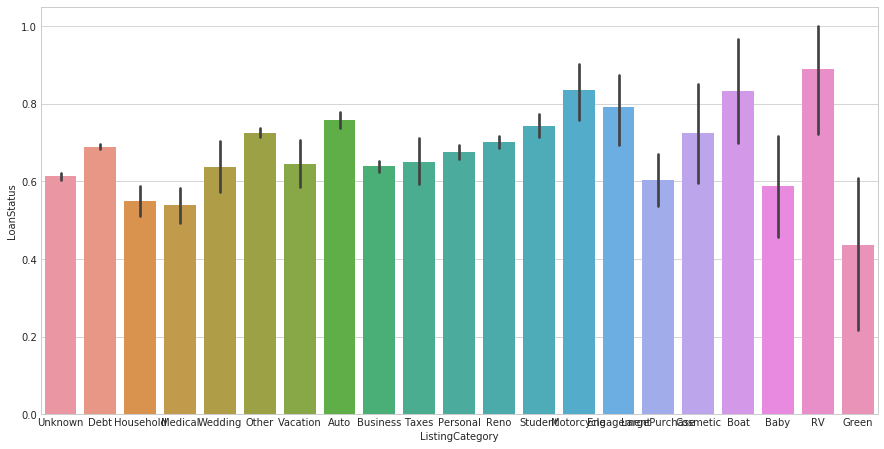

In [35]:
sns.barplot(x="ListingCategory", y="LoanStatus", data=df_historical)

In [36]:
rv, green = df_historical[df_historical["ListingCategory"] == "RV"], df_historical[df_historical["ListingCategory"] == "Green"]

1 - rv["LoanStatus"].mean(), 1 - green["LoanStatus"].mean()

(0.11111111111111116, 0.5652173913043479)

So, once again, certain types of loans seem to be outperforming others, with RV loans only defaulting 11.11% of the time, and green loans defaulting 56.52% of the time. Other frequent defaulters are loans for household expenses and for medical and dental work, while people seem to completely pay boat and motorcycle loans quite frequently. 

Let's examine some credit scoring metrics.

### Exploring the data: credit scores <a class="anchor" id="explore2"></a>

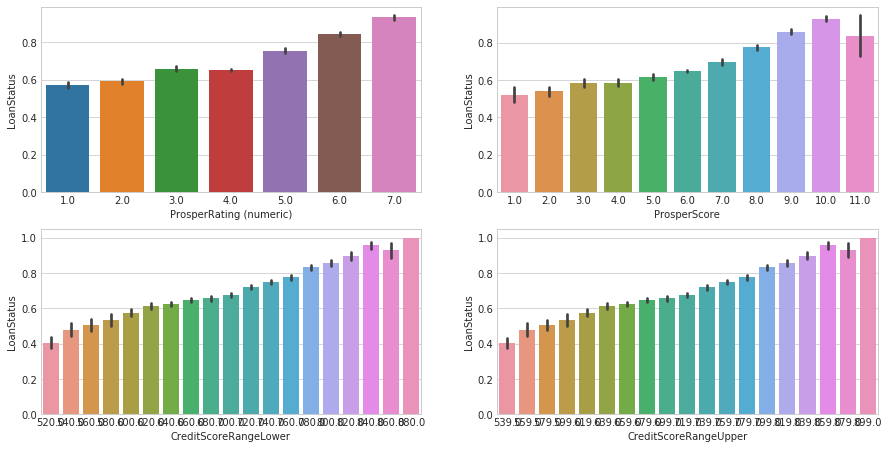

In [37]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.barplot(x="ProsperRating (numeric)", y="LoanStatus", data=df_historical)

ax2 = fig.add_subplot(222)
sns.barplot(x="ProsperScore", y="LoanStatus", data=df_historical)

ax3 = fig.add_subplot(223)
sns.barplot(x="CreditScoreRangeLower", y="LoanStatus", data=df_historical)

ax4 = fig.add_subplot(224)
sns.barplot(x="CreditScoreRangeUpper", y="LoanStatus", data=df_historical)

Both the Prosper scores and the credit scores seem to be doing a good job of predicting default, with higher ratings defaulting less frequently. Interestingly, the loans with the highest ProsperScores (11) default more frequently than loans rated at a 9 or a 10, and there is a high degree of variance in default rate for those highly rated loans.

It should be noted here that the credit score "range" seems to be constant. So let's quickly double-check that, and remove the redundancy by dropping CreditScoreRangeUpper and renaming the lower bound "CreditScore".

In [38]:
credit_score_range = df_historical["CreditScoreRangeUpper"] - df_historical["CreditScoreRangeLower"]

credit_score_range.value_counts()

19.0    49724
dtype: int64

In [39]:
df_historical.drop("CreditScoreRangeUpper", axis=1, inplace=True)

df_historical.rename(index=str, columns={"CreditScoreRangeLower": "CreditScore"}, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


Let's visualize some financial variables.

### Exploring the data: financial information <a class="anchor" id="explore3"></a>

(0, 400)

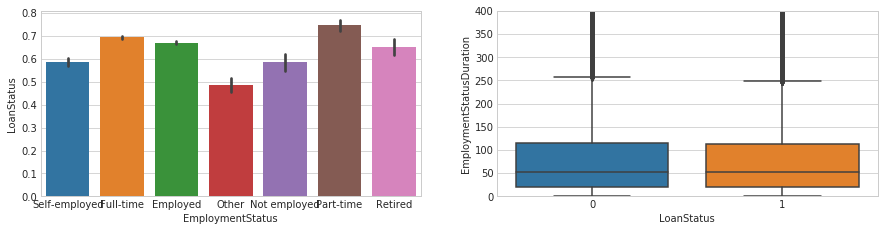

In [40]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.barplot(x="EmploymentStatus", y="LoanStatus", data=df_historical)

ax2 = fig.add_subplot(222)
sns.boxplot(x="LoanStatus", y="EmploymentStatusDuration", data=df_historical).set_ylim([0,400])

There doesn't seem to be a relationship between EmploymentStatusDuration and loan default. We'll take a look at the correlation in a moment. EmploymentStatus does, however, seem to have a relationship with default. Interestingly, part-time workers defaulted less often than full-time workers. People who listed their employment status as "Other" defaulted even more often than those who weren't employed at all.

In [41]:
x = df_historical["EmploymentStatusDuration"]
y = df_historical["LoanStatus"]

r, p = st.pearsonr(x, y)

print("The correlation between employment status duration and loan default is {}, with a p-value of {}".format(r, p))

The correlation between employment status duration and loan default is -0.0059057028589972775, with a p-value of 0.1878775422194832


The very weak correlation between employment status duration and loan default, as well as the lack of a statistically significant p-value, lead me to believe that we can safely drop this variable from our dataset.

In [42]:
df_historical.drop("EmploymentStatusDuration", axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Let's plot some income metrics and then some indicators of credit availability.

(0, 0.8)

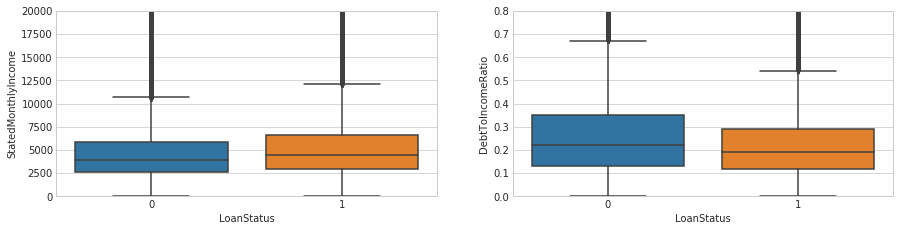

In [43]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.boxplot(x="LoanStatus", y="StatedMonthlyIncome", data=df_historical).set_ylim([0,20000])

ax2 = fig.add_subplot(222)
sns.boxplot(x="LoanStatus", y="DebtToIncomeRatio", data=df_historical).set_ylim([0,0.8])

Both monthly income and debt : income seem to have a relationship with default. People with higher stated incomes defaulted less often than those with lower incomes, regardless of the size of the loan. And as is intuitive, loans are more likely to default if the ratio of debt to income is higher. 

(0, 2.5)

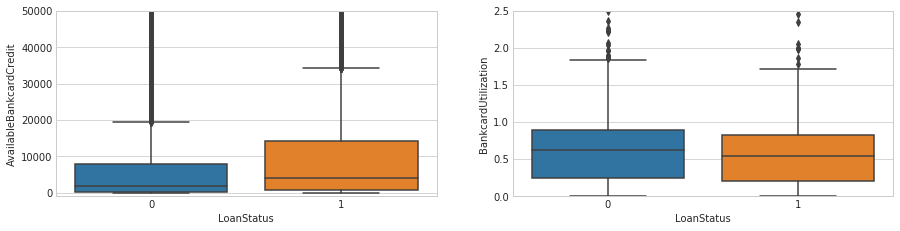

In [44]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.boxplot(x="LoanStatus", y="AvailableBankcardCredit", data=df_historical).set_ylim([-1000, 50000])

ax2 = fig.add_subplot(222)
sns.boxplot(x="LoanStatus", y="BankcardUtilization", data=df_historical).set_ylim([0,2.5])

We find a similar picture to income, wherein the availability of bankcard credit coincides with completed loans, and the lower the proportion of bankcard utilization, the lower the likelihood of default.

(0, 1)

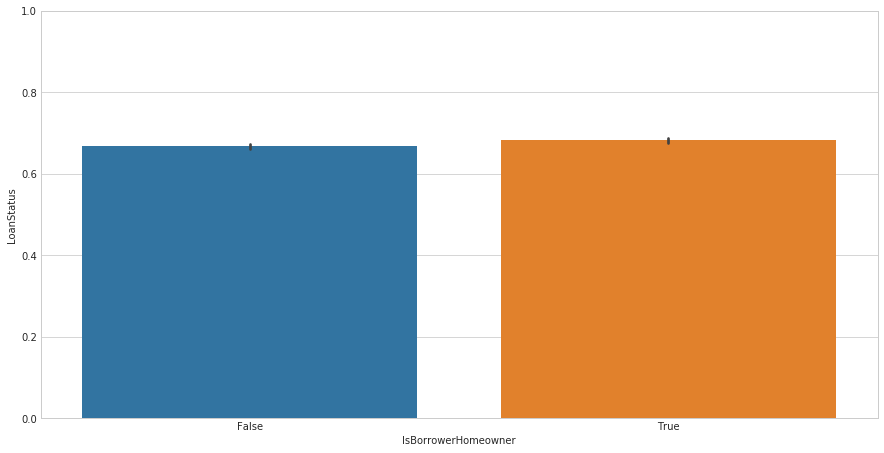

In [45]:
sns.barplot(x="IsBorrowerHomeowner", y="LoanStatus", data=df_historical).set_ylim([0,1])

It seems homeowners default very slightly less often than renters.

Next let's look at some credit history variables.

### Exploring the data: credit history <a class="anchor" id="explore4"></a>

(0, 20)

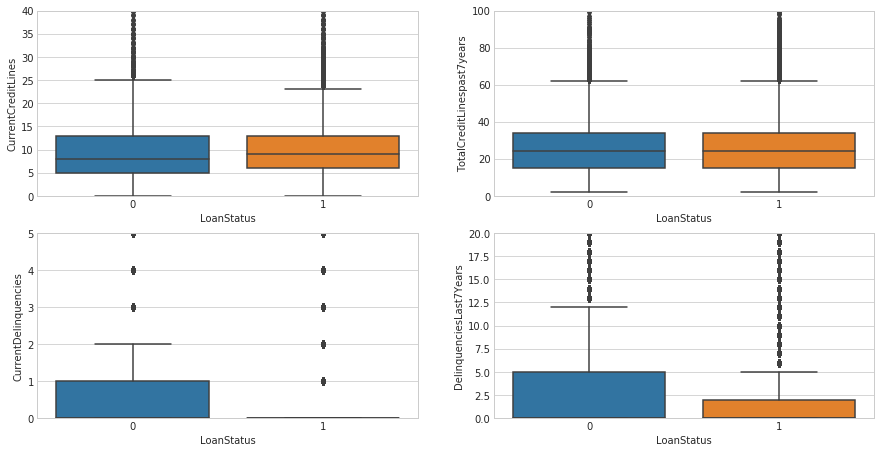

In [46]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.boxplot(x="LoanStatus", y="CurrentCreditLines", data=df_historical).set_ylim([0,40])

ax2 = fig.add_subplot(222)
sns.boxplot(x="LoanStatus", y="TotalCreditLinespast7years", data=df_historical).set_ylim([0,100])

ax3 = fig.add_subplot(223)
sns.boxplot(x="LoanStatus", y="CurrentDelinquencies", data=df_historical).set_ylim([0,5])

ax4 = fig.add_subplot(224)
sns.boxplot(x="LoanStatus", y="DelinquenciesLast7Years", data=df_historical).set_ylim([0,20])

Number of credit lines doesn't seem to have a particularly significant relationship with default, but delinquencies do. Among loans that were completed, it is very rare for the debtor to have any current delinquencies. Likewise, a history of delinquency seems to indicate a propensity for default. Let's take a look at those correlations.

In [47]:
delinquency = ["CurrentDelinquencies", "DelinquenciesLast7Years"]
y = df_historical["LoanStatus"]

for var in delinquency:
    x = df_historical[var]
    r, p = st.pearsonr(x, y)

    print("The correlation between {} and loan default is {}, with a p-value of {}".format(var, r, p))

The correlation between CurrentDelinquencies and loan default is -0.12107063477741749, with a p-value of 1.0845242651745478e-161
The correlation between DelinquenciesLast7Years and loan default is -0.06975250066577986, with a p-value of 1.1176410321268129e-54


Both current and historical delinquency correlate significantly (p < 0.05) with loan status. Current delinquencies in particular should be a very strong feature for us.

### Exploring the data: loan characteristics <a class="anchor" id="explore5"></a>

To wrap up, let's take a look at the characteristics of the loans themselves.

(10, 60)

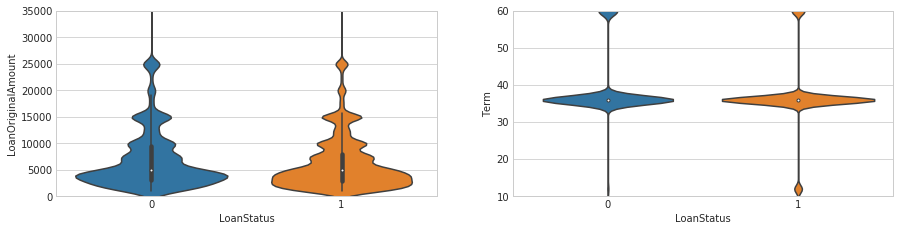

In [48]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.violinplot(x="LoanStatus", y="LoanOriginalAmount", data=df_historical).set_ylim([0,35000])

ax2 = fig.add_subplot(222)
sns.violinplot(x="LoanStatus", y="Term", data=df_historical).set_ylim([10, 60])

The distribution of the loan amount seems to be consistent between both classes. 

In [49]:
df_historical["Term"].value_counts()

36    43754
60     4418
12     1552
Name: Term, dtype: int64

Prosper loans can only have a term of 12, 36, or 60 months. By far the most common is the term of 3 years. Term probably won't be of much use to us to classify our loans either then. Let's wrap up by examining interest rates.

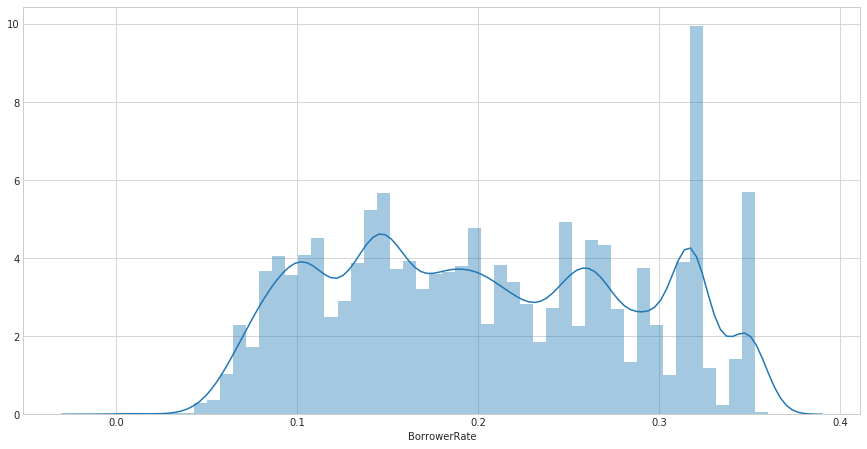

In [50]:
sns.distplot(df_historical["BorrowerRate"])

In [51]:
df_historical["BorrowerRate"].describe()

count    49724.000000
mean         0.203470
std          0.082468
min          0.000000
25%          0.136400
50%          0.199000
75%          0.270000
max          0.360000
Name: BorrowerRate, dtype: float64

The mean interest rate (without any fees) for all Prosper loans is a fairly substantial 20.35%. From my experience and a quick google, that is roughly equivalent to that of a credit card. The standard deviation is 8.25% however, meaning that the lowest 25% of borrowers are paying a much more reasonable 13.64%, but that the top 25% of borrowers are paying 27.00% and more, before fees!

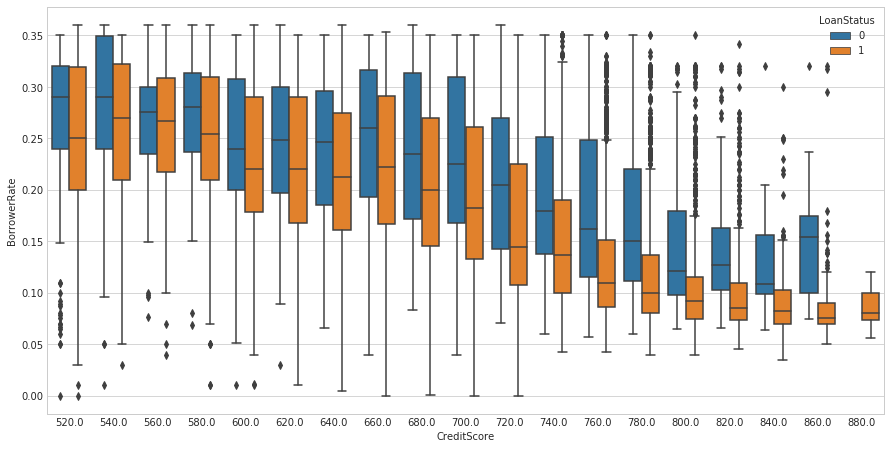

In [52]:
sns.boxplot(x="CreditScore", y='BorrowerRate', hue='LoanStatus', data=df_historical)

Generally, loans that default have a higher interest rate than loans that are paid completely, even when controlling for credit score. That makes sense, but it's still really cool to see in the chart above.

Right, so we've had the chance to take a look at some variables and their relationship to default. It seems there are a lot of good potential features available to us, although some of them are categorical and will need some work before we can use them in all of our classifiers.

### Dimensionality reduction: part 2 <a class="anchor" id="reduce2"></a>

In [53]:
df_historical.describe()

,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,CreditScore,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent (percentage),TradesOpenedLast6Months,DebtToIncomeRatio,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,LoanOriginalAmount,MonthlyLoanPayment,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
count,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,4.972400e+04,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.000000,49724.00000
mean,37.383316,0.674322,0.227630,0.203470,0.193209,0.171487,0.084773,0.099849,3.795129,6.098906,682.712171,9.586819,8.366242,25.789578,6.411210,347.684177,1.798287,6.556894,0.643914,1066.158435,4.143170,0.311178,0.023369,1.569520e+04,0.532345,10765.711789,21.844542,0.857704,0.907047,5.390154,5122.985416,0.301364,4.558624,4.412779,0.134040,0.011705,1617.444157,543.321921,6527.303495,232.774829,0.998274,0.099228,0.051022,37.083268,109.01818
std,8.200240,0.468632,0.089797,0.082468,0.082052,0.079151,0.042269,0.058222,1.365905,1.759049,66.713278,5.570450,4.980212,14.263379,4.454619,450.554180,2.739781,7.182246,2.000398,6717.698686,10.026401,0.744631,0.179542,3.380213e+04,0.349553,21926.061700,12.414067,0.172177,1.235013,47.175930,5695.264678,0.645141,11.410502,11.066557,1.105551,0.258911,4286.493397,1886.611584,5270.558892,186.245160,0.019836,0.476979,0.344454,443.751112,111.41890
min,12.000000,0.000000,0.006530,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,1.000000,520.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.000000,0.000000,0.700000,0.000000,0.000000,0.000000,1.00000
25%,36.000000,0.000000,0.153240,0.136400,0.125600,0.110200,0.072400,0.060300,3.000000,6.000000,640.000000,6.000000,5.000000,15.000000,3.000000,78.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.647000e+03,0.220000,512.000000,13.000000,0.770000,0.000000,0.120000,2916.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3000.000000,106.990000,1.000000,0.000000,0.000000,0.000000,33.00000
50%,36.000000,1.000000,0.222370,0.199000,0.188000,0.160850,0.072400,0.102500,4.000000,6.000000,680.000000,9.000000,8.000000,24.000000,6.000000,209.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.113500e+03,0.570000,3231.000000,20.000000,0.920000,1.000000,0.200000,4250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5000.000000,173.710000,1.000000,0.000000,0.000000,0.000000,73.00000
75%,36.000000,1.000000,0.305130,0.270000,0.259900,0.236400,0.100000,0.136300,4.000000,7.000000,720.000000,13.000000,11.000000,34.000000,9.000000,447.000000,2.000000,8.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.619825e+04,0.850000,11950.000000,29.000000,1.000000,1.000000,0.310000,6250.000000,0.000000,0.000000,0.00

I'm going to drop some further columns now that I don't think will help our model too much. Let me explain my thinking. The wide majority of loans were fully funded, and there are other variables (like Investors) capturing similar information, so I think it's safe to drop the PercentFunded variable. BorrowerAPR and LenderYield are both versions of BorrowerRate, just with fees included, so they're unnecessary. CreditGrade and ProsperRating (Alpha) are annoying categorical variables with many proxies already. IncomeRange is also a tricky data type and basically redundant. Occupation could be very interesting, but being such a broad categorical variable it would be incredibly difficult to use. Group affiliation could be an interesting line of inquiry, but I feel like that is probably best left to another investigation into Prosper's grouping practices. Finally, the estimated variables could be used as features, but I feel that since the entire point of this exercise is to outperform Prosper's estimates of risk, it is somewhat contradictory to use their precise estimates in our classifications. 

In [54]:
df_historical.drop(["CreditGrade", "BorrowerAPR", "LenderYield", "EstimatedEffectiveYield", "EstimatedLoss", "EstimatedReturn",
                 "ProsperRating (Alpha)", "Occupation", "CurrentlyInGroup", "GroupKey", "IncomeRange", "PercentFunded"], axis=1,
                inplace=True)

df_historical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49724 entries, 0 to 113935
Data columns (total 45 columns):
Term                                   49724 non-null int64
LoanStatus                             49724 non-null int64
BorrowerRate                           49724 non-null float64
ProsperRating (numeric)                49724 non-null float64
ProsperScore                           49724 non-null float64
ListingCategory                        49724 non-null object
BorrowerState                          49724 non-null object
EmploymentStatus                       49724 non-null object
IsBorrowerHomeowner                    49724 non-null bool
CreditScore                            49724 non-null float64
FirstRecordedCreditLine                49724 non-null object
CurrentCreditLines                     49724 non-null float64
OpenCreditLines                        49724 non-null float64
TotalCreditLinespast7years             49724 non-null float64
OpenRevolvingAccounts                 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Preprocessing: fixing data types <a class="anchor" id="dtypes"></a>

Let's quickly convert our boolean values into 0s and 1s for consistency's sake.

In [55]:
df_historical["IsBorrowerHomeowner"] = df_historical["IsBorrowerHomeowner"].astype(int)
df_historical["IncomeVerifiable"] = df_historical["IncomeVerifiable"].astype(int)

df_historical["IsBorrowerHomeowner"][:10], df_historical["IncomeVerifiable"][:10]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0     1
 11    0
 12    0
 15    1
 21    0
 23    0
 26    0
 27    1
 30    0
 33    0
 Name: IsBorrowerHomeowner, dtype: int64, 0     1
 11    1
 12    1
 15    1
 21    1
 23    1
 26    1
 27    1
 30    1
 33    1
 Name: IncomeVerifiable, dtype: int64)

Lovely. Now, let's turn our attention to those powerful categorical variables. Of the 4 remaining variables of type "object", one stands out: FirstRecordedCreditLine. It could be a datetime object, let's take a look.

In [56]:
df_historical["FirstRecordedCreditLine"][:10]

0     2001-10-11 00:00:00
11    2000-11-13 00:00:00
12    1996-11-09 00:00:00
15    1999-03-08 00:00:00
21    2003-06-20 00:00:00
23    1998-06-09 00:00:00
26    1975-10-26 00:00:00
27    2000-04-11 00:00:00
30    1988-06-01 00:00:00
33    2003-12-01 00:00:00
Name: FirstRecordedCreditLine, dtype: object

The length of credit history could potentially be a very powerful feature so I'd like to keep this if possible. Let's try turning this variable into a "YearsWithCredit" variable that will take continuous integer values rather than being a datetime object. This data comes from 2014, so let's compare the earliest recorded credit lines to 2014.

In [57]:
first_credit_year = df_historical["FirstRecordedCreditLine"].str[:4]

df_historical["YearsWithCredit"] = 2014 - pd.to_numeric(first_credit_year)

df_historical.drop("FirstRecordedCreditLine", axis=1, inplace=True)

df_historical["YearsWithCredit"][:10]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


0     13
11    14
12    18
15    15
21    11
23    16
26    39
27    14
30    26
33    11
Name: YearsWithCredit, dtype: int64

We're left with 3 variables of type "object" that need to be cleaned up: ListingCategory, BorrowerState and EmploymentStatus. Let's create dummy variables for each of these and join them to the high_yield dataframe. BorrowerState has, of course, 50 possible values (52 actually, counting DC and "Unknown"), so with that one I'm first going to group states into a few bins depending on their rates of default.

In [58]:
category = pd.get_dummies(df_historical["ListingCategory"])

df_historical = df_historical.join(category, rsuffix="_category")
df_historical.drop("ListingCategory", axis=1, inplace=True)

df_historical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49724 entries, 0 to 113935
Data columns (total 65 columns):
Term                                   49724 non-null int64
LoanStatus                             49724 non-null int64
BorrowerRate                           49724 non-null float64
ProsperRating (numeric)                49724 non-null float64
ProsperScore                           49724 non-null float64
BorrowerState                          49724 non-null object
EmploymentStatus                       49724 non-null object
IsBorrowerHomeowner                    49724 non-null int64
CreditScore                            49724 non-null float64
CurrentCreditLines                     49724 non-null float64
OpenCreditLines                        49724 non-null float64
TotalCreditLinespast7years             49724 non-null float64
OpenRevolvingAccounts                  49724 non-null int64
OpenRevolvingMonthlyPayment            49724 non-null float64
InquiriesLast6Months                 

In [59]:
employment = pd.get_dummies(df_historical["EmploymentStatus"])

df_historical = df_historical.join(employment, rsuffix="_employmentstatus")
df_historical.drop("EmploymentStatus", axis=1, inplace=True)

df_historical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49724 entries, 0 to 113935
Data columns (total 71 columns):
Term                                   49724 non-null int64
LoanStatus                             49724 non-null int64
BorrowerRate                           49724 non-null float64
ProsperRating (numeric)                49724 non-null float64
ProsperScore                           49724 non-null float64
BorrowerState                          49724 non-null object
IsBorrowerHomeowner                    49724 non-null int64
CreditScore                            49724 non-null float64
CurrentCreditLines                     49724 non-null float64
OpenCreditLines                        49724 non-null float64
TotalCreditLinespast7years             49724 non-null float64
OpenRevolvingAccounts                  49724 non-null int64
OpenRevolvingMonthlyPayment            49724 non-null float64
InquiriesLast6Months                   49724 non-null float64
TotalInquiries                      

In [60]:
state_defaults = df_historical.groupby("BorrowerState")["LoanStatus"].mean()

vlow_risk = sorted(state_defaults)[51]
low_risk = sorted(state_defaults)[40]
mid_risk = sorted(state_defaults)[29]
high_risk = sorted(state_defaults)[19]
vhigh_risk = sorted(state_defaults)[9]

new_geography = {}

for state in state_defaults.index:
    if high_risk > state_defaults[state]:
        v = "StateVeryHighRisk"
    elif mid_risk > state_defaults[state] >= high_risk:
        v = "StateHighRisk"
    elif low_risk > state_defaults[state] >= mid_risk:
        v = "StateMidRisk"
    elif vlow_risk > state_defaults[state] >= low_risk:
        v = "StateLowRisk"
    else:
        v = "StateVeryLowRisk"
    new_geography[state] = v

df_historical.replace(to_replace={"BorrowerState": new_geography}, inplace=True)
                               
df_historical["BorrowerState"][:10]

0          StateLowRisk
11    StateVeryHighRisk
12    StateVeryHighRisk
15    StateVeryHighRisk
21        StateHighRisk
23        StateHighRisk
26         StateLowRisk
27         StateLowRisk
30        StateHighRisk
33        StateHighRisk
Name: BorrowerState, dtype: object

In [61]:
state = pd.get_dummies(df_historical["BorrowerState"])

df_historical = df_historical.join(state, rsuffix="_state")
df_historical.drop("BorrowerState", axis=1, inplace=True)

df_historical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49724 entries, 0 to 113935
Data columns (total 75 columns):
Term                                   49724 non-null int64
LoanStatus                             49724 non-null int64
BorrowerRate                           49724 non-null float64
ProsperRating (numeric)                49724 non-null float64
ProsperScore                           49724 non-null float64
IsBorrowerHomeowner                    49724 non-null int64
CreditScore                            49724 non-null float64
CurrentCreditLines                     49724 non-null float64
OpenCreditLines                        49724 non-null float64
TotalCreditLinespast7years             49724 non-null float64
OpenRevolvingAccounts                  49724 non-null int64
OpenRevolvingMonthlyPayment            49724 non-null float64
InquiriesLast6Months                   49724 non-null float64
TotalInquiries                         49724 non-null float64
CurrentDelinquencies               

### Train/test split <a class="anchor" id="split"></a>

Now let's split our data into features and labels, as well as training and testing sets.

In [62]:
X = df_historical.drop("LoanStatus", axis=1)
y = df_historical["LoanStatus"]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Preprocessing: scaling features to a range <a class="anchor" id="scale"></a>

Let's scale our values to adapt them to some of our classifiers. I'm going to scale the values to a range between 0 and 1, as this will preserve our important 0 values, as well as having the added benefit of "robustness to very small standard deviations of features" (http://scikit-learn.org/stable/modules/preprocessing.html).

In [64]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Reducing dimensionality: part 3 <a class="anchor" id="reduce3"></a>

Let's now perform both some principal component analysis and some univariate feature selection and save the transformed data to new variables so we can see if the further reductions in dimensionality can positively impact either accuracy or fit performance in a meaningful way. I'm going to be running the scaled data through these transformers, since this will keep the variances PCA compares against one another consistent.

In [65]:
pca = PCA(n_components=10)
pca.fit(X_train_scaled)

X_train_pca10 = pca.transform(X_train_scaled)
X_test_pca10 = pca.transform(X_test_scaled)

pca.explained_variance_ratio_

array([ 0.17670123,  0.11838247,  0.09699779,  0.08818248,  0.07777252,
        0.05738194,  0.05187247,  0.04803878,  0.04100428,  0.03370387])

In [66]:
pca = PCA(n_components=3)
pca.fit(X_train)

X_train_pca3 = pca.transform(X_train_scaled)
X_test_pca3 = pca.transform(X_test_scaled)

pca.explained_variance_ratio_

array([ 0.68228994,  0.24762512,  0.02503526])

Finally, let's select the best 50%, and best 10% of features. 

In [67]:
X_train_reduce50 = SelectPercentile(percentile=50).fit_transform(X_train_scaled, y_train)
X_test_reduce50 = SelectPercentile(percentile=50).fit_transform(X_test_scaled, y_test)

X_train_reduce10 = SelectPercentile().fit_transform(X_train_scaled, y_train)
X_test_reduce10 = SelectPercentile().fit_transform(X_test_scaled, y_test)

### Choosing a classifier <a class="anchor" id="class"></a>

Alright, before we start training potential classifiers and comparing them to one another let's take a moment to think about what our goals are and what metrics will quantify that performance. While it is true that in a general sense we are trying to accurately predict (or classify) which loans will default and which loans will be completely paid back, the real goal is to minimize lending to eventual defaults. Thus our goal is in fact to correctly classify as many defaults as possible, even if that means erring on the side of caution by occasionally classifying a true completion as a default. This is a matter, not of accuracy across our two (unbalanced, mind you) classes, but of maximizing recall for default classification even at the expense of precision. Recall will be the most relevant metric for our purposes.

I'm going to try an unusually broad selection of classifiers with a wide variety of training data (original, scaled, with reduced features, etc.) and provide their main performance metrics in a "results" dataframe. Because sklearn's metrics by default consider positives and assume binary positives are encoded as 1, I'll specify, using the "pos_label" parameter, that our true focus is on default or 0. Finally, I know that as our LDA is fit during cross validation it will throw several collinearity warnings. Those aren't of great importance to our goal of prediction, so we will suppress them for ease of output.

In [68]:
import warnings

models = {"Logistic Regression": LogisticRegression(), "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
          "Gaussian Naive Bayes": GaussianNB(), "Decision Tree Classifier": DecisionTreeClassifier(),
          "Random Forest Classifier": RandomForestClassifier(), "AdaBoost Classifier": AdaBoostClassifier()}

data = {"": X_train, "(scaled data)": X_train_scaled, "(PCA: 10 components)": X_train_pca10, "(PCA: 3 components)": X_train_pca3,
        "(50% of features)": X_train_reduce50, "(10% of features)": X_train_reduce10}

res = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for name, model in models.items():
        for scale, X in data.items():
            n = name + " " + scale
            clf = model
            s0, m0 = datetime.datetime.now().time().second, datetime.datetime.now().time().minute
            acc = cross_val_score(clf, X, y_train).mean()
            s1, m1 = datetime.datetime.now().time().second, datetime.datetime.now().time().minute
            y_pred = cross_val_predict(clf, X, y_train)
            default_recall = make_scorer(recall_score, pos_label=0, average="binary")
            default_precision = make_scorer(precision_score, pos_label=0, average="binary")
            default_fscore = make_scorer(f1_score, pos_label=0, average="binary")
            rec = cross_val_score(clf, X, y_train, scoring=default_recall).mean()
            prec = cross_val_score(clf, X, y_train, scoring=default_precision).mean()
            f1 = cross_val_score(clf, X, y_train, scoring=default_fscore).mean()
            m_delta = m1 - m0
            s_delta = s1 - s0
            if s_delta < 0:
                s_delta = 60 + s_delta
                m_delta -= 1

            res[n] = {"MeanAccuracy": acc, "Precision": prec, "Recall": rec, "F1Score": f1, 
                      "TrainingTime (m)": m_delta, "TrainingTime (s)": s_delta}

results = pd.DataFrame.from_dict(res, orient="index")
results = results[["MeanAccuracy", "Precision", "Recall", "F1Score", "TrainingTime (m)", "TrainingTime (s)"]]

results

,MeanAccuracy,Precision,Recall,F1Score,TrainingTime (m),TrainingTime (s)
AdaBoost Classifier,0.710643,0.596942,0.344764,0.437069,0,12
AdaBoost Classifier (10% of features),0.688454,0.566568,0.186544,0.280643,0,3
AdaBoost Classifier (50% of features),0.706979,0.590977,0.328373,0.421956,0,9
AdaBoost Classifier (PCA: 10 components),0.681035,0.532540,0.172073,0.260087,0,9
AdaBoost Classifier (PCA: 3 components),0.672901,0.485894,0.058021,0.103625,0,3
AdaBoost Classifier (scaled data),0.710643,0.596942,0.344764,0.437069,0,15
Decision Tree Classifier,0.629237,0.430917,0.445375,0.435601,0,4
Decision Tree Classifier (10% of features),0.604031,0.395859,0.419381,0.411701,0,0
Decision Tree Classifier (50% of features),0.627383,0.430686,0.443111,0.435496,0,2
Decision Tree Classifier (PCA: 10 components),0.610065,0.405139,0.416364,0.410309,0,2


In [69]:
results["Recall"].argmax(), results["Recall"].max()

('Gaussian Naive Bayes (scaled data)', 0.66505390317210777)

In terms of recall and, therefore, suitability to our purposes, it doesn't look great. 

First, let's just note that our classifiers took anywhere from < 1s to 10s to train on the three different sets generated during our cross validation scoring. That's not too bad, and has allowed us to compare a wide variety of possible models. In fact, I decided to leave out a popular classifier (SVC) because of how long it was taking to train. That performance is to be expected though: according to the scikitlearn documentation (http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), "The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples."

Second, a quick word on accuracy: as hinted above, accuracy can be an incredibly misleading metric when applied to unbalanced classes like this. Take a look at Logistic Regression using the data reduced to 3 principal components. It has a decent accuracy score of 0.6742, but it scored a 0 in both precision and recall! This model is doing nothing but reflecting the distribution of our underlying classes, and scoring 67% by just labelling everything as a completion. If we hadn't taken precision and recall into account, we could have missed that. I think that the unbalanced classes could be contributing to what I think is some pretty underwhelming initial performance, so parameter tuning will take on an added performance here, as we can try to penalize models heftily and bring them more into line with our goal of maximizing recall on the default class. 

Imbalanced classes are a really interesting problem in machine learning, and classes far more imbalanced than these pop up in a variety of domains. The concepts and approaches applied here could be applied in a similar way to problems ranging from fraud detection to marketing, so I'm keen to really think things through and try to do things rigorously. There is a fantastic, highly-readable paper that discusses approaches to imbalanced data (in the context of a random forest classifier) that can be found here: http://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf. A lot of my methodology has been drawn from intuitions confirmed in that paper.

Third, our top recall performer was a Gaussian Naive Bayes classifier using the scaled data. With a recall of 66.51%, this classifier correctly flagged more than half of the defaults in our historical data, so that's something. That classifier also had the highest F1 score (the harmonic mean of precision and recall). 

Now let's turn our attention to parameter tuning, in the hopes that some penalty and class weight parameters might be able to bring up the recall of some other models in a meaningful way.

## Parameter tuning <a class="anchor" id="tuning"></a>

Our top performer, GaussianNB, doesn't actually have any parameters to tune. The only way we'll be able to improve its performance will be to re-adjust the class weights in our training data to be more balanced, that's fairly trivial to implement, but let's focus on another classifier instead. Our next best classifier in terms of recall was a Random Forest Classifier running on the best 50% of features (with a default recall score of 0.4581). Let's begin by tuning that. The main parameter for our purposes is the class weights, which can be penalized in the Random Forest object itself, unlike Naive Bayes. The other parameters in a Random Forest Classifier for the most part either describe the size of the split (and thus a bias variance tradeoff) or tune performance.

In [70]:
default_recall = make_scorer(recall_score, pos_label=0)

param_grid = {"class_weight": ["balanced", {0: 2, 1: 1}, {0: 5, 1: 1}, {0: 10, 1: 1}], "min_samples_split": [2, 3, 5, 10, 20]}

forest = RandomForestClassifier()
clf = GridSearchCV(forest, param_grid=param_grid, scoring=default_recall)

clf.fit(X_train_reduce50, y_train)

clf.best_params_, clf.best_score_ 

({'class_weight': {0: 10, 1: 1}, 'min_samples_split': 20}, 0.7321861873514083)

In [71]:
(.7389 - .4581) / .4581

0.6129666011787819

61.29%. That's great! We've increased our recall performance . However, I see here that the parameters that maximize default recall involve penalizing completed loans by a factor of 10:1 in deciding splits, and making each of the tree leaves a maximum of 10 samples large. I imagine this has hurt our precision quite a bit. Let's take a look.

In [72]:
default_precision = make_scorer(precision_score, pos_label=0, average="binary")
default_fscore = make_scorer(f1_score, pos_label=0, average="binary")

rec = cross_val_score(clf, X_train_reduce50, y_train, scoring=default_recall).mean()
prec = cross_val_score(clf, X_train_reduce50, y_train, scoring=default_precision).mean()
f = cross_val_score(clf, X_train_reduce50, y_train, scoring=default_fscore).mean()


print(" Recall: {} \n Precision: {} \n F1 Score: {}".format(rec, prec, f))

 Recall: 0.7417870292061702 
 Precision: 0.44121569473436706 
 F1 Score: 0.5514894349668219


Fantastic. We see here that by increasing recall we have reduced our precision (from 49.80% to 43.60%), a classic tradeoff. While we have identified 73.69% of all of the eventual defaults as such, only 43.60% of the cases classified as eventual defaults actually were.

There's a lot that we could do to improve recall even further, such as forcing the random forest to underfit even more at the expense of precision, or increasing the number of decision trees in the forest at the expense of performance. Perhaps resampling the data (as improving the Naive Bayes classifier would demand) could improve the random forest even more in conjunction with the above parameter tuning.

Nonetheless, since this is more of a learning exercise than a real life attempt to profit off Prosper loans, I'm keen to apply our newly tuned classifier to our test data and wrap things up. Let's give that a try.

### Predicting defaults <a class="anchor" id="predict"></a>

Let's use our fit and tuned random forest classifier to make some default predictions on our test data, then let's consider our performance in terms of the returns we would achieve if we lent to all the of the predicted completions (with actual defaults paying 0, in the name of simplicity and conservatism.

In [73]:
clf = RandomForestClassifier(class_weight={0: 10, 1: 1}, min_samples_split=20)
clf.fit(X_train_reduce50, y_train)

pred = clf.predict(X_test_reduce50)

pred = pd.Series(pred, index=[y_test.index], name='Predicted')

predictions = pd.concat([y_test, pred], axis=1)

predictions[:10]

,LoanStatus,Predicted
109437,0,1
45931,0,1
51959,1,1
4234,0,1
100716,1,1
58140,1,1
16325,1,1
20462,0,1
647,0,1
73359,1,1


In [74]:
loans_chosen = predictions[predictions["Predicted"] == 1]

loans_chosen[:10]

,LoanStatus,Predicted
109437,0,1
45931,0,1
51959,1,1
4234,0,1
100716,1,1
58140,1,1
16325,1,1
20462,0,1
647,0,1
73359,1,1


In [75]:
loans_failed = loans_chosen[loans_chosen["LoanStatus"] == 0]
loans_success = loans_chosen[loans_chosen["LoanStatus"] == 1]

len(loans_failed), len(loans_success), len(loans_failed) / (len(loans_success) + len(loans_failed))

(1560, 3260, 0.3236514522821577)

So, in terms of simple quantities, if we were to have used our classifier and only lent money to those loans predicted to be completions, 1570 of those loans (or 32.91% of total lending) would have "defaulted" (remembering always that our definition of default includes all loans with payments past-due, charge-offs and cancellations). Not great, but then, to be perfectly honest, we didn't expect it to be. Let's see what our actual dollar losses (or gains) would have been.

In [76]:
lost_money = X_test.loc[loans_failed.index,"LoanOriginalAmount"]

lost_money.sum()

10907829

Using our (very conservative) definition of a default or "bad" loan meaning a loss of all the principal (and assuming we were the only lender for each of these loans) we would have lost a whopping $10,794,185.00 lending to these borrowers. There's always the hope that the interest from our successful loans could mitigate that a bit, let's take a look.

In [77]:
a = X_test.loc[loans_success.index,"LoanOriginalAmount"]
b = X_test.loc[loans_success.index,"BorrowerRate"]

gained_money = pd.concat([a, b], axis=1)

gained_money["Profit"] = gained_money["LoanOriginalAmount"] * gained_money["BorrowerRate"]

gained_money[:10]

,LoanOriginalAmount,BorrowerRate,Profit
51959,4700,0.2699,1268.5300
100716,9999,0.1523,1522.8477
58140,6500,0.2499,1624.3500
16325,20000,0.1675,3350.0000
73359,1500,0.3375,506.2500
30047,3500,0.3500,1225.0000
79487,20000,0.1419,2838.0000
105808,1000,0.0710,71.0000
56359,1000,0.0680,68.0000
21316,25000,0.1364,3410.0000


In [78]:
gained_money["Profit"].sum()

3628301.8322999906

Well, that's something. Lending to successful loans would have gained us a respectable $3,568,850.17 in interest payments.

In [79]:
total_losses = gained_money["Profit"].sum() - lost_money.sum()
total_return = total_losses / (gained_money["LoanOriginalAmount"].sum() + lost_money.sum())

total_losses, total_return

(-7279527.1677000094, -0.22796795325564265)

So, if we had been the sole lender to all of these loans, and used our random forest classifier to decide who and who not to lend to, we would have lost an absolutely irresponsible sum of money: $7,225,334.83. That would give us a return of -23.25%--before fees! Clearly our classifier isn't quite ready for the real world just yet.

### Conclusion <a class="anchor" id="end"></a>

So, let's wrap things up. I'm pretty happy with this project. Our recall isn't phenomenal, and would certainly not be good enough to justify risking real money on Prosper, nor for an important application such as fraud detection, but it's been a great experience. I got great practice in cleaning and preprocessing a dataset, as well as using seaborn for some sexy visualisations and, most importantly, choosing appropriate metrics for a particular problem definition. I'm sure that with some more time, and, of course, some more learning, I could bring up the returns of our hypothetical loan portfolio. But the purpose of this notebook was never to make money, it was to learn and to practice. Maybe I'll return to it someday soon to apply some new techniques or understanding. For now, let's take a break from Prosper, and move on to the next project.